# Overview

1. Pre-train Model 

+ Train a feature representation of a protein sequence based on NLP methods such as doc2vec or word2vec on a large-scale database (uniprot_sprot.fasta). 

+ Use the expression method obtained in the previous step to obtain descriptors from the protein sequence of the reaction data set.

+ Apply traditional machine learning models that are good at handling small-scale data sets to train and evaluate the descriptors and labels of the reaction data set.

2. AAindex as Descriptors
+ Finally, it also shows the training result of using only the AAindex descriptor of the changed amino acid site as the feature.


# Data processing 

+ In view of the fact that there are only 20 amino acids and the diversity is not enough, we take amino acid triplet as the basic "word".

## Uniprot_sprot.fasta

In [1]:
import pandas as pd
import numpy as np
import json
from itertools import product
from glob import glob
import os 


src_dir = r'H-data'
codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']


class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)


def Mers_dict_generator(src_dir=src_dir, json_f=None, codes=codes):
    json_f = '3mers_dict.json' if not json_f else json_f
    json_f = r'%s/%s' % (src_dir, json_f)
    if os.path.isfile(json_f):
        with open(json_f, 'r') as f:
            Mers_dict = json.load(f)
    else:
        start_num = 1
        Mers_dict = {"**"+k: v+start_num for v, k in enumerate(codes)}
        _Mers_dict = {k+"**": v+start_num+len(codes)
                      for v, k in enumerate(codes)}
        Mers_dict.update(_Mers_dict)
        start_num += len(codes)*2
        mers2 = list(product(codes, codes))
        for i, v in enumerate(mers2):
            Mers_dict["*"+"".join(list(v))] = i+start_num
            Mers_dict["".join(list(v))+"*"] = i+start_num+len(mers2)
        start_num += len(mers2)*2
        mers3 = list(product(codes, codes, codes))
        for i, v in enumerate(mers3):
            Mers_dict["".join(list(v))] = i+start_num
        json_str = json.dumps(Mers_dict, indent=4, cls=NpEncoder)
        with open(json_f, 'w') as json_file:
            json_file.write(json_str)
    return Mers_dict


In [2]:
Mers_dict_generator(src_dir=src_dir, json_f=None)

{'**A': 1,
 '**C': 2,
 '**D': 3,
 '**E': 4,
 '**F': 5,
 '**G': 6,
 '**H': 7,
 '**I': 8,
 '**K': 9,
 '**L': 10,
 '**M': 11,
 '**N': 12,
 '**P': 13,
 '**Q': 14,
 '**R': 15,
 '**S': 16,
 '**T': 17,
 '**V': 18,
 '**W': 19,
 '**Y': 20,
 'A**': 21,
 'C**': 22,
 'D**': 23,
 'E**': 24,
 'F**': 25,
 'G**': 26,
 'H**': 27,
 'I**': 28,
 'K**': 29,
 'L**': 30,
 'M**': 31,
 'N**': 32,
 'P**': 33,
 'Q**': 34,
 'R**': 35,
 'S**': 36,
 'T**': 37,
 'V**': 38,
 'W**': 39,
 'Y**': 40,
 '*AA': 41,
 'AA*': 441,
 '*AC': 42,
 'AC*': 442,
 '*AD': 43,
 'AD*': 443,
 '*AE': 44,
 'AE*': 444,
 '*AF': 45,
 'AF*': 445,
 '*AG': 46,
 'AG*': 446,
 '*AH': 47,
 'AH*': 447,
 '*AI': 48,
 'AI*': 448,
 '*AK': 49,
 'AK*': 449,
 '*AL': 50,
 'AL*': 450,
 '*AM': 51,
 'AM*': 451,
 '*AN': 52,
 'AN*': 452,
 '*AP': 53,
 'AP*': 453,
 '*AQ': 54,
 'AQ*': 454,
 '*AR': 55,
 'AR*': 455,
 '*AS': 56,
 'AS*': 456,
 '*AT': 57,
 'AT*': 457,
 '*AV': 58,
 'AV*': 458,
 '*AW': 59,
 'AW*': 459,
 '*AY': 60,
 'AY*': 460,
 '*CA': 61,
 'CA*': 461,
 '*C

In [3]:
import uniprot
import re


def getSubSeq(seq, loc, length):
    return seq[loc:loc+length]


def read_Fasta(src_fasta):
    if os.path.isfile(src_dir):
        seqids, seqdict = uniprot.read_fasta(src_fasta)
        regex = re.compile('(?<=OS=)(.*)(?= OX=)')
        proteins = [seqdict[i]['sequence'] for i in seqids]
        descriptions = np.array([seqdict[i]['description'] for i in seqids])
        labels = np.array([regex.findall(i)[0] for i in descriptions])
        human_index = np.where(labels == 'Homo sapiens')[0]
        human_proteins = [proteins[i]
                      for i in range(len(proteins)) if i in human_index]
        return human_proteins
    elif isinstance(src_fasta, np.ndarray):
        return src_fasta


class FastaReader:
    def __init__(self, cutoff=32):
        self.Mers_dict = "Please use self.get_Mers_dict(src_dir, json_f) to get Mers_dict"
        self.cutoff = cutoff
        self.files_dict = dict()
        self.prots = "Please use build_Peptides_dataset(dst_npz, src_fasta) to get prots, peptides, tokens"
        self.peptides = "Please use build_Peptides_dataset(vsrc_fasta) to get prots, peptides, tokens"
        self.tokens = "Please use build_Peptides_dataset(dst_npz, src_fasta) to get prots, peptides, tokens"

    def get_Mers_dict(self, src_dir=src_dir, json_f=None):
        json_f = '3mers_dict.json' if not json_f else json_f
        self.files_dict['Mers_dict.json'] = '%s/%s' % (src_dir, json_f)
        self.Mers_dict = Mers_dict_generator(src_dir, json_f)

    def build_Peptides_dataset(self, dst_npz=None, src_fasta=None):
        dst_npz = os.path.join(src_dir, 'Peptides_%s_dataset.npz' % (
            self.cutoff)) if not dst_npz else dst_npz
        if os.path.isfile(dst_npz):
            self.files_dict['dst_npz.npz'] = dst_npz
            npzfile = np.load(dst_npz, allow_pickle=True)
            self.prots = pd.DataFrame(npzfile['prots'], columns=['prots'])
            self.peptides = npzfile['peptides']
            self.words = npzfile['words']
            self.tokens = npzfile['tokens']
        elif not isinstance(src_fasta, type(None)):
            dst_dir = os.path.dirname(dst_npz)
            if not os.path.isdir(dst_dir):
                os.makedirs(dst_dir)
            self.files_dict['src_fasta.fasta'] = src_fasta
            self.files_dict['dst_npz.npz'] = dst_npz
            prots = read_Fasta(src_fasta)
            df = pd.DataFrame(np.array(prots), columns=['prots'])
            df = df[(df.prots.str.count('B|Z|X|U|O') == 0)]
            df = df[(df.prots.str.len() >= self.cutoff)]
            peptides = np.expand_dims(np.concatenate(
                df.prots.apply(self.split).values), 1)
            words = np.apply_along_axis(self._get3Mers, 1, peptides)
            tokens = np.apply_along_axis(self._tokenization, 1, words)
            self.prots = df
            self.peptides = peptides
            self.words = words
            self.tokens = tokens
            np.savez(dst_npz, prots=df.prots.values,
                     peptides=peptides, words=words, tokens=tokens)

    def split(self, prot):
        cutoff = self.cutoff
        # Cutting proteins into equal peptide lengths
        prot = prot.replace(' ', '')
        lenth_ = len(prot)
        # Seq will be cut into q+1 segments
        q = lenth_//cutoff
        mod = lenth_ % cutoff
        if mod:
            # Length of each overlapping section
            overlap_len = (cutoff - mod)//q
            # Counts of segments with length of overlap_len + 1
            overlap1_ct = (cutoff - mod) % q
            # The shorter lenth of each segments between two cut point
            seg_len = cutoff-overlap_len
            step_point = (seg_len-1)*overlap1_ct
            if step_point > 0:
                cut_point = list(range(0, step_point, seg_len-1)) + \
                    list(range(step_point, lenth_-cutoff+1, seg_len))
            else:
                cut_point = list(range(0, lenth_-cutoff+1, seg_len))
        else:
            cut_point = list(range(0, lenth_, cutoff))
        Peptides = np.array(
            [getSubSeq(prot, x, cutoff) for x in cut_point])
        return Peptides

    def _get3Mers(self, seq):
        # tokenization with 3-mers
        if type(seq) == np.ndarray:
            seq = seq[0]
        words = []
        _len = len(seq)+2
        for i in range(_len):
            if i == 0:
                words.append('**'+seq[0])
            elif i == 1:
                words.append('*'+seq[0:2])
            elif i == _len - 1:
                words.append(seq[-1:]+'**')
            elif i == _len - 2:
                words.append(seq[-2:]+'*')
            else:
                words.append(seq[i-2:i+1])
        words = np.array(words)
        return words

    def _tokenization(self, words):
        return np.array([self.Mers_dict[w] for w in words])
    
    def rebuild_data(self):
        '''Non-overlapping segmented amino acid sequence '''
        words = self.words
        tokens = self.tokens
        w1 = words[:, 0:-2:3]
        w2 = words[:, 1:-1:3]
        w3 = words[:, 2::3]
        words = np.concatenate((w1, w2, w3), axis=0)
        t1 = tokens[:, 0:-2:3]
        t2 = tokens[:, 1:-1:3]
        t3 = tokens[:, 2::3]
        tokens = np.concatenate((t1, t2, t3), axis=0)
        return words, tokens

In [4]:
src_fasta = '%s/uniprot_sprot.fasta'%src_dir
json_f = '3mers_dict.json'
dst_npz = '%s/Peptides_dataset.npz'%src_dir

uniprot_reader = FastaReader(cutoff=25)
uniprot_reader.get_Mers_dict(src_dir, json_f)
uniprot_reader.build_Peptides_dataset(dst_npz, src_fasta)

In [5]:
uniprot_reader.peptides

array([['MTMDKSELVQKAKLAEQAERYDDMA'],
       ['AAAMKAVTEQGHELSNEERNLLSVA'],
       ['AYKNVVGARRSSWRVISSIEQKTER'],
       ...,
       ['EPIQGVRWHCQDCPPEMSLDFCDSC'],
       ['SDCLHETDIHKEDHQLEPIYRSETF'],
       ['LDRDYCVSQGTSYNYLDPNYFPANR']], dtype='<U25')

In [6]:
uniprot_reader.words.shape

(463784, 27)

In [7]:
uniprot_reader.words

array([['**M', '*MT', 'MTM', ..., 'DMA', 'MA*', 'A**'],
       ['**A', '*AA', 'AAA', ..., 'SVA', 'VA*', 'A**'],
       ['**A', '*AY', 'AYK', ..., 'TER', 'ER*', 'R**'],
       ...,
       ['**E', '*EP', 'EPI', ..., 'DSC', 'SC*', 'C**'],
       ['**S', '*SD', 'SDC', ..., 'ETF', 'TF*', 'F**'],
       ['**L', '*LD', 'LDR', ..., 'ANR', 'NR*', 'R**']], dtype='<U3')

In [8]:
words, tokens = uniprot_reader.rebuild_data()
words

array([['**M', 'TMD', 'KSE', ..., 'QAE', 'RYD', 'DMA'],
       ['**A', 'AAM', 'KAV', ..., 'EER', 'NLL', 'SVA'],
       ['**A', 'YKN', 'VVG', ..., 'SSI', 'EQK', 'TER'],
       ...,
       ['EPI', 'QGV', 'RWH', ..., 'LDF', 'CDS', 'C**'],
       ['SDC', 'LHE', 'TDI', ..., 'IYR', 'SET', 'F**'],
       ['LDR', 'DYC', 'VSQ', ..., 'NYF', 'PAN', 'R**']], dtype='<U3')

In [9]:
words.shape

(1391352, 9)

## Reaction data set

In [10]:
df = pd.read_csv(r'H-data/prodata.csv',index_col=0)
df

,0,1
0,YSALMCKVVADGTLKVKFDIIEPALA,0.400000
1,YSALMCKVVADGTLKVKFFIFEPALA,-0.082000
2,YSALMCKVVADGTLKVKFFINEPALA,0.208000
3,YSALMCKVVADGTLKVKFHIIEPALA,0.620000
4,YSALMCKVVADGTLKVKFIIREPALA,0.352000
...,...,...
169,YSALMFKVVADGTLKVKFIIVEPALA,0.169131
170,YSALMVKVVADGTLKVKFFIIEPALA,0.352127
171,YSALMVKVVADGTLKVKFSIYEPALA,0.312151
172,YSALMIKVVADGTLKVKFIICEPALA,0.186633


In [11]:
# prepare for Doc2Vec
df['head_str'] = df.iloc[:, 0].apply(lambda x: x[:-1])
df['tail_str'] = df.iloc[:, 0].apply(lambda x: x[1:])
df

,0,1,head_str,tail_str
0,YSALMCKVVADGTLKVKFDIIEPALA,0.400000,YSALMCKVVADGTLKVKFDIIEPAL,SALMCKVVADGTLKVKFDIIEPALA
1,YSALMCKVVADGTLKVKFFIFEPALA,-0.082000,YSALMCKVVADGTLKVKFFIFEPAL,SALMCKVVADGTLKVKFFIFEPALA
2,YSALMCKVVADGTLKVKFFINEPALA,0.208000,YSALMCKVVADGTLKVKFFINEPAL,SALMCKVVADGTLKVKFFINEPALA
3,YSALMCKVVADGTLKVKFHIIEPALA,0.620000,YSALMCKVVADGTLKVKFHIIEPAL,SALMCKVVADGTLKVKFHIIEPALA
4,YSALMCKVVADGTLKVKFIIREPALA,0.352000,YSALMCKVVADGTLKVKFIIREPAL,SALMCKVVADGTLKVKFIIREPALA
...,...,...,...,...
169,YSALMFKVVADGTLKVKFIIVEPALA,0.169131,YSALMFKVVADGTLKVKFIIVEPAL,SALMFKVVADGTLKVKFIIVEPALA
170,YSALMVKVVADGTLKVKFFIIEPALA,0.352127,YSALMVKVVADGTLKVKFFIIEPAL,SALMVKVVADGTLKVKFFIIEPALA
171,YSALMVKVVADGTLKVKFSIYEPALA,0.312151,YSALMVKVVADGTLKVKFSIYEPAL,SALMVKVVADGTLKVKFSIYEPALA
172,YSALMIKVVADGTLKVKFIICEPALA,0.186633,YSALMIKVVADGTLKVKFIICEPAL,SALMIKVVADGTLKVKFIICEPALA


In [12]:
# prepare for Word2Vec

## Here we only consider the triplet centered on the changing position 
## Considering that there are three changing positions, 
## we finally concatenate the three word representations directly into one-dimensional features 
df['key_words'] = df.iloc[:, 0].apply(lambda x: (x[4:7], x[17:20], x[19:22]))
df

,0,1,head_str,tail_str,key_words
0,YSALMCKVVADGTLKVKFDIIEPALA,0.400000,YSALMCKVVADGTLKVKFDIIEPAL,SALMCKVVADGTLKVKFDIIEPALA,"(MCK, FDI, IIE)"
1,YSALMCKVVADGTLKVKFFIFEPALA,-0.082000,YSALMCKVVADGTLKVKFFIFEPAL,SALMCKVVADGTLKVKFFIFEPALA,"(MCK, FFI, IFE)"
2,YSALMCKVVADGTLKVKFFINEPALA,0.208000,YSALMCKVVADGTLKVKFFINEPAL,SALMCKVVADGTLKVKFFINEPALA,"(MCK, FFI, INE)"
3,YSALMCKVVADGTLKVKFHIIEPALA,0.620000,YSALMCKVVADGTLKVKFHIIEPAL,SALMCKVVADGTLKVKFHIIEPALA,"(MCK, FHI, IIE)"
4,YSALMCKVVADGTLKVKFIIREPALA,0.352000,YSALMCKVVADGTLKVKFIIREPAL,SALMCKVVADGTLKVKFIIREPALA,"(MCK, FII, IRE)"
...,...,...,...,...,...
169,YSALMFKVVADGTLKVKFIIVEPALA,0.169131,YSALMFKVVADGTLKVKFIIVEPAL,SALMFKVVADGTLKVKFIIVEPALA,"(MFK, FII, IVE)"
170,YSALMVKVVADGTLKVKFFIIEPALA,0.352127,YSALMVKVVADGTLKVKFFIIEPAL,SALMVKVVADGTLKVKFFIIEPALA,"(MVK, FFI, IIE)"
171,YSALMVKVVADGTLKVKFSIYEPALA,0.312151,YSALMVKVVADGTLKVKFSIYEPAL,SALMVKVVADGTLKVKFSIYEPALA,"(MVK, FSI, IYE)"
172,YSALMIKVVADGTLKVKFIICEPALA,0.186633,YSALMIKVVADGTLKVKFIICEPAL,SALMIKVVADGTLKVKFIICEPALA,"(MIK, FII, ICE)"


In [13]:
# prepare for AAindex method

## Here we only consider the Amino acid centered on the changing position
## Considering that there are three changing positions, 
## we finally concatenate the three AAindex descriptors directly into one-dimensional features 
df['key_AA'] = df.iloc[:, 0].apply(lambda x: [x[5], x[18], x[20]])
df

,0,1,head_str,tail_str,key_words,key_AA
0,YSALMCKVVADGTLKVKFDIIEPALA,0.400000,YSALMCKVVADGTLKVKFDIIEPAL,SALMCKVVADGTLKVKFDIIEPALA,"(MCK, FDI, IIE)","[C, D, I]"
1,YSALMCKVVADGTLKVKFFIFEPALA,-0.082000,YSALMCKVVADGTLKVKFFIFEPAL,SALMCKVVADGTLKVKFFIFEPALA,"(MCK, FFI, IFE)","[C, F, F]"
2,YSALMCKVVADGTLKVKFFINEPALA,0.208000,YSALMCKVVADGTLKVKFFINEPAL,SALMCKVVADGTLKVKFFINEPALA,"(MCK, FFI, INE)","[C, F, N]"
3,YSALMCKVVADGTLKVKFHIIEPALA,0.620000,YSALMCKVVADGTLKVKFHIIEPAL,SALMCKVVADGTLKVKFHIIEPALA,"(MCK, FHI, IIE)","[C, H, I]"
4,YSALMCKVVADGTLKVKFIIREPALA,0.352000,YSALMCKVVADGTLKVKFIIREPAL,SALMCKVVADGTLKVKFIIREPALA,"(MCK, FII, IRE)","[C, I, R]"
...,...,...,...,...,...,...
169,YSALMFKVVADGTLKVKFIIVEPALA,0.169131,YSALMFKVVADGTLKVKFIIVEPAL,SALMFKVVADGTLKVKFIIVEPALA,"(MFK, FII, IVE)","[F, I, V]"
170,YSALMVKVVADGTLKVKFFIIEPALA,0.352127,YSALMVKVVADGTLKVKFFIIEPAL,SALMVKVVADGTLKVKFFIIEPALA,"(MVK, FFI, IIE)","[V, F, I]"
171,YSALMVKVVADGTLKVKFSIYEPALA,0.312151,YSALMVKVVADGTLKVKFSIYEPAL,SALMVKVVADGTLKVKFSIYEPALA,"(MVK, FSI, IYE)","[V, S, Y]"
172,YSALMIKVVADGTLKVKFIICEPALA,0.186633,YSALMIKVVADGTLKVKFIICEPAL,SALMIKVVADGTLKVKFIICEPALA,"(MIK, FII, ICE)","[I, I, C]"


In [14]:
key_prot = np.concatenate((df.head_str.values, df.tail_str.values), axis=0)
y = np.concatenate((df.iloc[:, 1], df.iloc[:, 1]), axis=0)
key_prot

array(['YSALMCKVVADGTLKVKFDIIEPAL', 'YSALMCKVVADGTLKVKFFIFEPAL',
       'YSALMCKVVADGTLKVKFFINEPAL', 'YSALMCKVVADGTLKVKFHIIEPAL',
       'YSALMCKVVADGTLKVKFIIREPAL', 'YSALMCKVVADGTLKVKFVICEPAL',
       'YSALMCKVVADGTLKVKFVILEPAL', 'YSALMCKVVADGTLKVKFVIYEPAL',
       'YSALMCKVVADGTLKVKFYISEPAL', 'YSALMDKVVADGTLKVKFFIFEPAL',
       'YSALMDKVVADGTLKVKFGIFEPAL', 'YSALMDKVVADGTLKVKFVIGEPAL',
       'YSALMDKVVADGTLKVKFYIFEPAL', 'YSALMFKVVADGTLKVKFCIHEPAL',
       'YSALMFKVVADGTLKVKFFICEPAL', 'YSALMFKVVADGTLKVKFFIGEPAL',
       'YSALMFKVVADGTLKVKFFILEPAL', 'YSALMFKVVADGTLKVKFFINEPAL',
       'YSALMFKVVADGTLKVKFGIFEPAL', 'YSALMFKVVADGTLKVKFGIYEPAL',
       'YSALMFKVVADGTLKVKFIIFEPAL', 'YSALMFKVVADGTLKVKFIIGEPAL',
       'YSALMFKVVADGTLKVKFLISEPAL', 'YSALMFKVVADGTLKVKFRIFEPAL',
       'YSALMFKVVADGTLKVKFVIFEPAL', 'YSALMFKVVADGTLKVKFVIHEPAL',
       'YSALMFKVVADGTLKVKFVIVEPAL', 'YSALMGKVVADGTLKVKFCIFEPAL',
       'YSALMGKVVADGTLKVKFDINEPAL', 'YSALMGKVVADGTLKVKFGICEPAL',
       'YSALMGKVVADGTLKVK

In [15]:
print(len(key_prot), len(key_prot[0]))

348 25


In [16]:
dst_npz2 = '%s/Key_prot_dataset.npz'%src_dir

uniprot_reader.build_Peptides_dataset(dst_npz2, key_prot)
words2, tokens2 = uniprot_reader.rebuild_data()
words2

array([['**Y', 'SAL', 'MCK', ..., 'KFD', 'IIE', 'PAL'],
       ['**Y', 'SAL', 'MCK', ..., 'KFF', 'IFE', 'PAL'],
       ['**Y', 'SAL', 'MCK', ..., 'KFF', 'INE', 'PAL'],
       ...,
       ['SAL', 'MVK', 'VVA', ..., 'IYE', 'PAL', 'A**'],
       ['SAL', 'MIK', 'VVA', ..., 'ICE', 'PAL', 'A**'],
       ['SAL', 'MVK', 'VVA', ..., 'IRE', 'PAL', 'A**']], dtype='<U3')

# Models preparation

In [17]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR, LinearSVR
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from xgboost import XGBRegressor

In [18]:
RF_R = RandomForestRegressor(n_estimators=100, criterion='mse')
Ada_R = AdaBoostRegressor()
GB_R = GradientBoostingRegressor()

NN_R = MLPRegressor(
    hidden_layer_sizes=(100, 100,),
    activation='relu', 
    solver='adam', 
    alpha=0.0001, 
    batch_size='auto', 
    learning_rate='constant', 
    learning_rate_init=0.001)

DTree_R = DecisionTreeRegressor(criterion='mse')

LR_R = linear_model.LinearRegression()

Lasso_R = linear_model.Lasso()

Ridge_R = linear_model.Ridge()

BRR_R = linear_model.BayesianRidge()

KRR_R = KernelRidge()

SVR_R = SVR(kernel='rbf', degree=3, gamma='auto')

LSVR_R = LinearSVR()

SGD_R = linear_model.SGDRegressor()

KNR_R = KNeighborsRegressor()

GPR_R = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel())

XGB_R = XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=100)

In [19]:
reg_lib = { 'RF_R'    : RF_R,    'Ada_R'  : Ada_R,   'GB_R' : GB_R,  'DTree_R': DTree_R, 'LR_R' : LR_R, 
            'Lasso_R' : Lasso_R, 'Ridge_R': Ridge_R, 'BRR_R': BRR_R, 'KRR_R'  : KRR_R,   'SVR_R': SVR_R, 
            'LSVR_R'  : LSVR_R,  'SGD_R'  : SGD_R,   'KNR_R': KNR_R, 'GPR_R'  : GPR_R,    'NN_R': NN_R,    'XGB_R': XGB_R}

In [20]:
from sklearn.model_selection import cross_validate
from sklearn.utils import shuffle
from joblib import Parallel, delayed
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import time


def get_CV_res(model, X, y):
    cv_results = dict()
    y_pred = cross_val_predict(model, X, y, cv=5)
    R2 = r2_score(y, y_pred)
    MAE = mean_absolute_error(y, y_pred)
    MSE = mean_squared_error(y, y_pred)

    cv_results['R2'] = np.round(R2, decimals=4)
    cv_results['MAE'] = np.round(MAE, decimals=4)
    cv_results['MSE'] = np.round(MSE, decimals=4)

    return y_pred, cv_results

def _CV_reg_fit(X, y, reg_name, reg):
    '''column for reg_summary: ['Model', 'MAE', 'MSE', 'R2']'''
    
    y_pred, reg_res = get_CV_res(reg, X, y)
    reg_res['Regressor'] = reg_name
    reg_summary = [reg_name, reg_res['MAE'], reg_res['MSE'], reg_res['R2']]

    return reg_summary, y_pred, reg_res


def CV_fit(X, y, model_lib=None, model_dict=None, n_jobs=2, parallel=False):
    start_time = time.time()
    model_res = dict()
    history = dict()
    y_pred_dict = {'y': y}
    if n_jobs:
        n_jobs = min(n_jobs, len(model_dict))
    if parallel:
        res = Parallel(n_jobs=n_jobs, prefer="threads")(
                delayed(_CV_reg_fit)(X, y, m_name, model) for m_name, model in model_dict.items())
        
        for i, m_name in enumerate(model_dict.keys()):
            j = list(model_lib.keys()).index(m_name)
            summary, y_pred, tmp_res = res[i]
            model_res[j] = summary
            
            y_pred_dict[m_name] = y_pred
            history[m_name] = tmp_res
    else:
        for i, (m_name, model) in enumerate(model_dict.items()):
            j = list(model_lib.keys()).index(m_name)
            summary, y_pred, tmp_res = _CV_reg_fit(X, y, m_name, model)
            model_res[j] = summary
            
            y_pred_dict[m_name] = y_pred
            history[m_name] = tmp_res
            
    column = ['Model', 'MAE', 'MSE', 'R2']
    res_df = pd.DataFrame.from_dict(model_res, orient='index', 
                columns=column).sort_values(by=['R2'], ascending=False)
    end_time = time.time()
    Timestamp = time.strftime(
        '%Y.%m.%d %H:%M:%S', time.localtime(end_time))
    print(Timestamp, 'complete!')
    print('    Time cost: %.4fs' %(end_time-start_time))
    return res_df, y_pred_dict, history


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

def Plot_True_vs_Pred(y_pred_dict, model_list=None, title='Actual vs Predict', low=None, up=None, figure_file=None):
    sns.set(style='whitegrid', palette='muted', color_codes=True)
    low = low if low!=None else -12
    up = up if up!=None else 12
    fig = plt.figure(figsize=(50,40))
    y_true = y_pred_dict['y']
    if isinstance(model_list, type(None)):
        mn = list(y_pred_dict.keys())[1:]
    else:
        mn = model_list
    for i in range(len(model_list)):
        ax = plt.subplot(4, 4, i+1)
        y_pred = y_pred_dict[mn[i]]
        plt.scatter(y_true, y_pred,  color='green')
        plt.plot((low,up), (low,up), color='blue', linewidth=3)
        plt.tick_params(axis='both', which='major', labelsize=18)
        plt.xlabel(xlabel=r'Actual', fontsize=24)
        plt.ylabel(ylabel=r'Predict', fontsize=24)
        R2 = r2_score(y_true, y_pred)
        MAE = mean_absolute_error(y_true, y_pred)
        MSE = mean_squared_error(y_true, y_pred)
        title = mn[i][:-2]+'\nR$^2$: %.3f, MAE: %.2f, MSE: %.2f'%(R2, MAE, MSE)
        plt.title(label=title, fontsize=28)
    
    plt.subplots_adjust(wspace =0.3, hspace =0.4)#调整子图间距
    if figure_file != None:
        plt.savefig(figure_file, dpi=300)
    plt.show()


# Doc2Vec

## Uniprot  corpus

In [22]:
# pre-train

from gensim.models.doc2vec import Doc2Vec, TaggedDocument


doc2vec_pkl=r"H-data/uniprot_25cut_3mers_non_overlaped_doc2vec_model.pkl"
if os.path.isfile(doc2vec_pkl):
    doc2vec_model = Doc2Vec.load(doc2vec_pkl)
else:
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(words)]
    doc2vec_model = Doc2Vec(documents, vector_size=32, window=5, min_count=1, workers=8, epochs=10)
    doc2vec_model.save(doc2vec_pkl)

/home/user/miniconda/envs/py36/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [23]:
X = np.apply_along_axis(doc2vec_model.infer_vector, axis=1, arr=words2)
y = np.concatenate((y, y, y), axis=0)
X

array([[ 0.6215566 , -0.29075757, -0.03092208, ...,  0.17438428,
         0.02154505,  0.17830905],
       [ 0.42295563, -0.24350384,  0.03315992, ...,  0.20261323,
         0.15564409,  0.088099  ],
       [ 0.5200777 , -0.2802259 ,  0.02066732, ...,  0.20870104,
         0.10100109,  0.16308963],
       ...,
       [ 0.13215819, -0.00599844, -0.19002697, ...,  0.10322167,
         0.09122604,  0.07550438],
       [-0.096529  ,  0.09893695, -0.19580166, ...,  0.02582477,
         0.11990049,  0.087538  ],
       [-0.05577749,  0.0357776 , -0.22319546, ...,  0.08723269,
         0.14020565,  0.10648504]], dtype=float32)

In [24]:
X.shape

(1044, 32)

In [25]:
idx = ~np.isnan(y)
X, y = X[idx], y[idx]

X, y = shuffle(X, y, random_state=1024)
res_df, y_pred_dict, history = CV_fit(X, y, model_lib=reg_lib, model_dict={'RF_R': RF_R, 'NN_R': NN_R }, n_jobs=2, parallel=False)
res_df

2021.05.30 16:02:45 complete!
    Time cost: 7.4879s


,Model,MAE,MSE,R2
14,NN_R,0.1969,0.0774,-0.0249
0,RF_R,0.1988,0.0788,-0.0429


In [26]:
res_df, y_pred_dict, history = CV_fit(X, y, model_lib=reg_lib, model_dict=reg_lib, n_jobs=2, parallel=False)
res_df

2021.05.30 16:02:59 complete!
    Time cost: 13.9900s


,Model,MAE,MSE,R2
13,GPR_R,0.1919,0.0726,0.0387
6,Ridge_R,0.1906,0.0729,0.0348
4,LR_R,0.1931,0.0729,0.0344
7,BRR_R,0.1909,0.0729,0.0343
10,LSVR_R,0.1876,0.0742,0.0174
8,KRR_R,0.1932,0.0744,0.0147
9,SVR_R,0.1919,0.0746,0.0124
11,SGD_R,0.1961,0.0757,-0.0025
5,Lasso_R,0.1961,0.0757,-0.0026
14,NN_R,0.1974,0.0766,-0.0147


In [27]:
y_pred_dict

{'y': array([0.16913092, 0.33805081, 0.246902  , ..., 0.1316    , 0.582     ,
        0.20439921]),
 'RF_R': array([0.23323739, 0.23453599, 0.24548903, ..., 0.34701757, 0.14047867,
        0.37254748]),
 'Ada_R': array([0.26176654, 0.28914974, 0.28247303, ..., 0.36199287, 0.2970961 ,
        0.3698905 ]),
 'GB_R': array([ 0.25686278,  0.25410221,  0.30267963, ...,  0.30068207,
        -0.17634018,  0.37818388]),
 'DTree_R': array([ 0.35212654, -0.268     ,  0.5875306 , ...,  0.4593782 ,
         0.192     ,  0.75      ]),
 'LR_R': array([0.25573942, 0.26572275, 0.21075168, ..., 0.33410847, 0.45489165,
        0.38865617], dtype=float32),
 'Lasso_R': array([0.32687816, 0.32687816, 0.32687816, ..., 0.32117575, 0.32117575,
        0.32117575], dtype=float32),
 'Ridge_R': array([0.28465664, 0.27970183, 0.30175865, ..., 0.32768843, 0.35666555,
        0.37001723], dtype=float32),
 'BRR_R': array([0.27035269, 0.27547027, 0.28291782, ..., 0.32745466, 0.3680019 ,
        0.37719685]),
 'KRR_R'

In [28]:
res_df.Model.values

array(['GPR_R', 'Ridge_R', 'LR_R', 'BRR_R', 'LSVR_R', 'KRR_R', 'SVR_R',
       'SGD_R', 'Lasso_R', 'NN_R', 'Ada_R', 'RF_R', 'GB_R', 'KNR_R',
       'XGB_R', 'DTree_R'], dtype=object)

In [29]:
print(y.min(), y.max())

-1.0 0.925603606


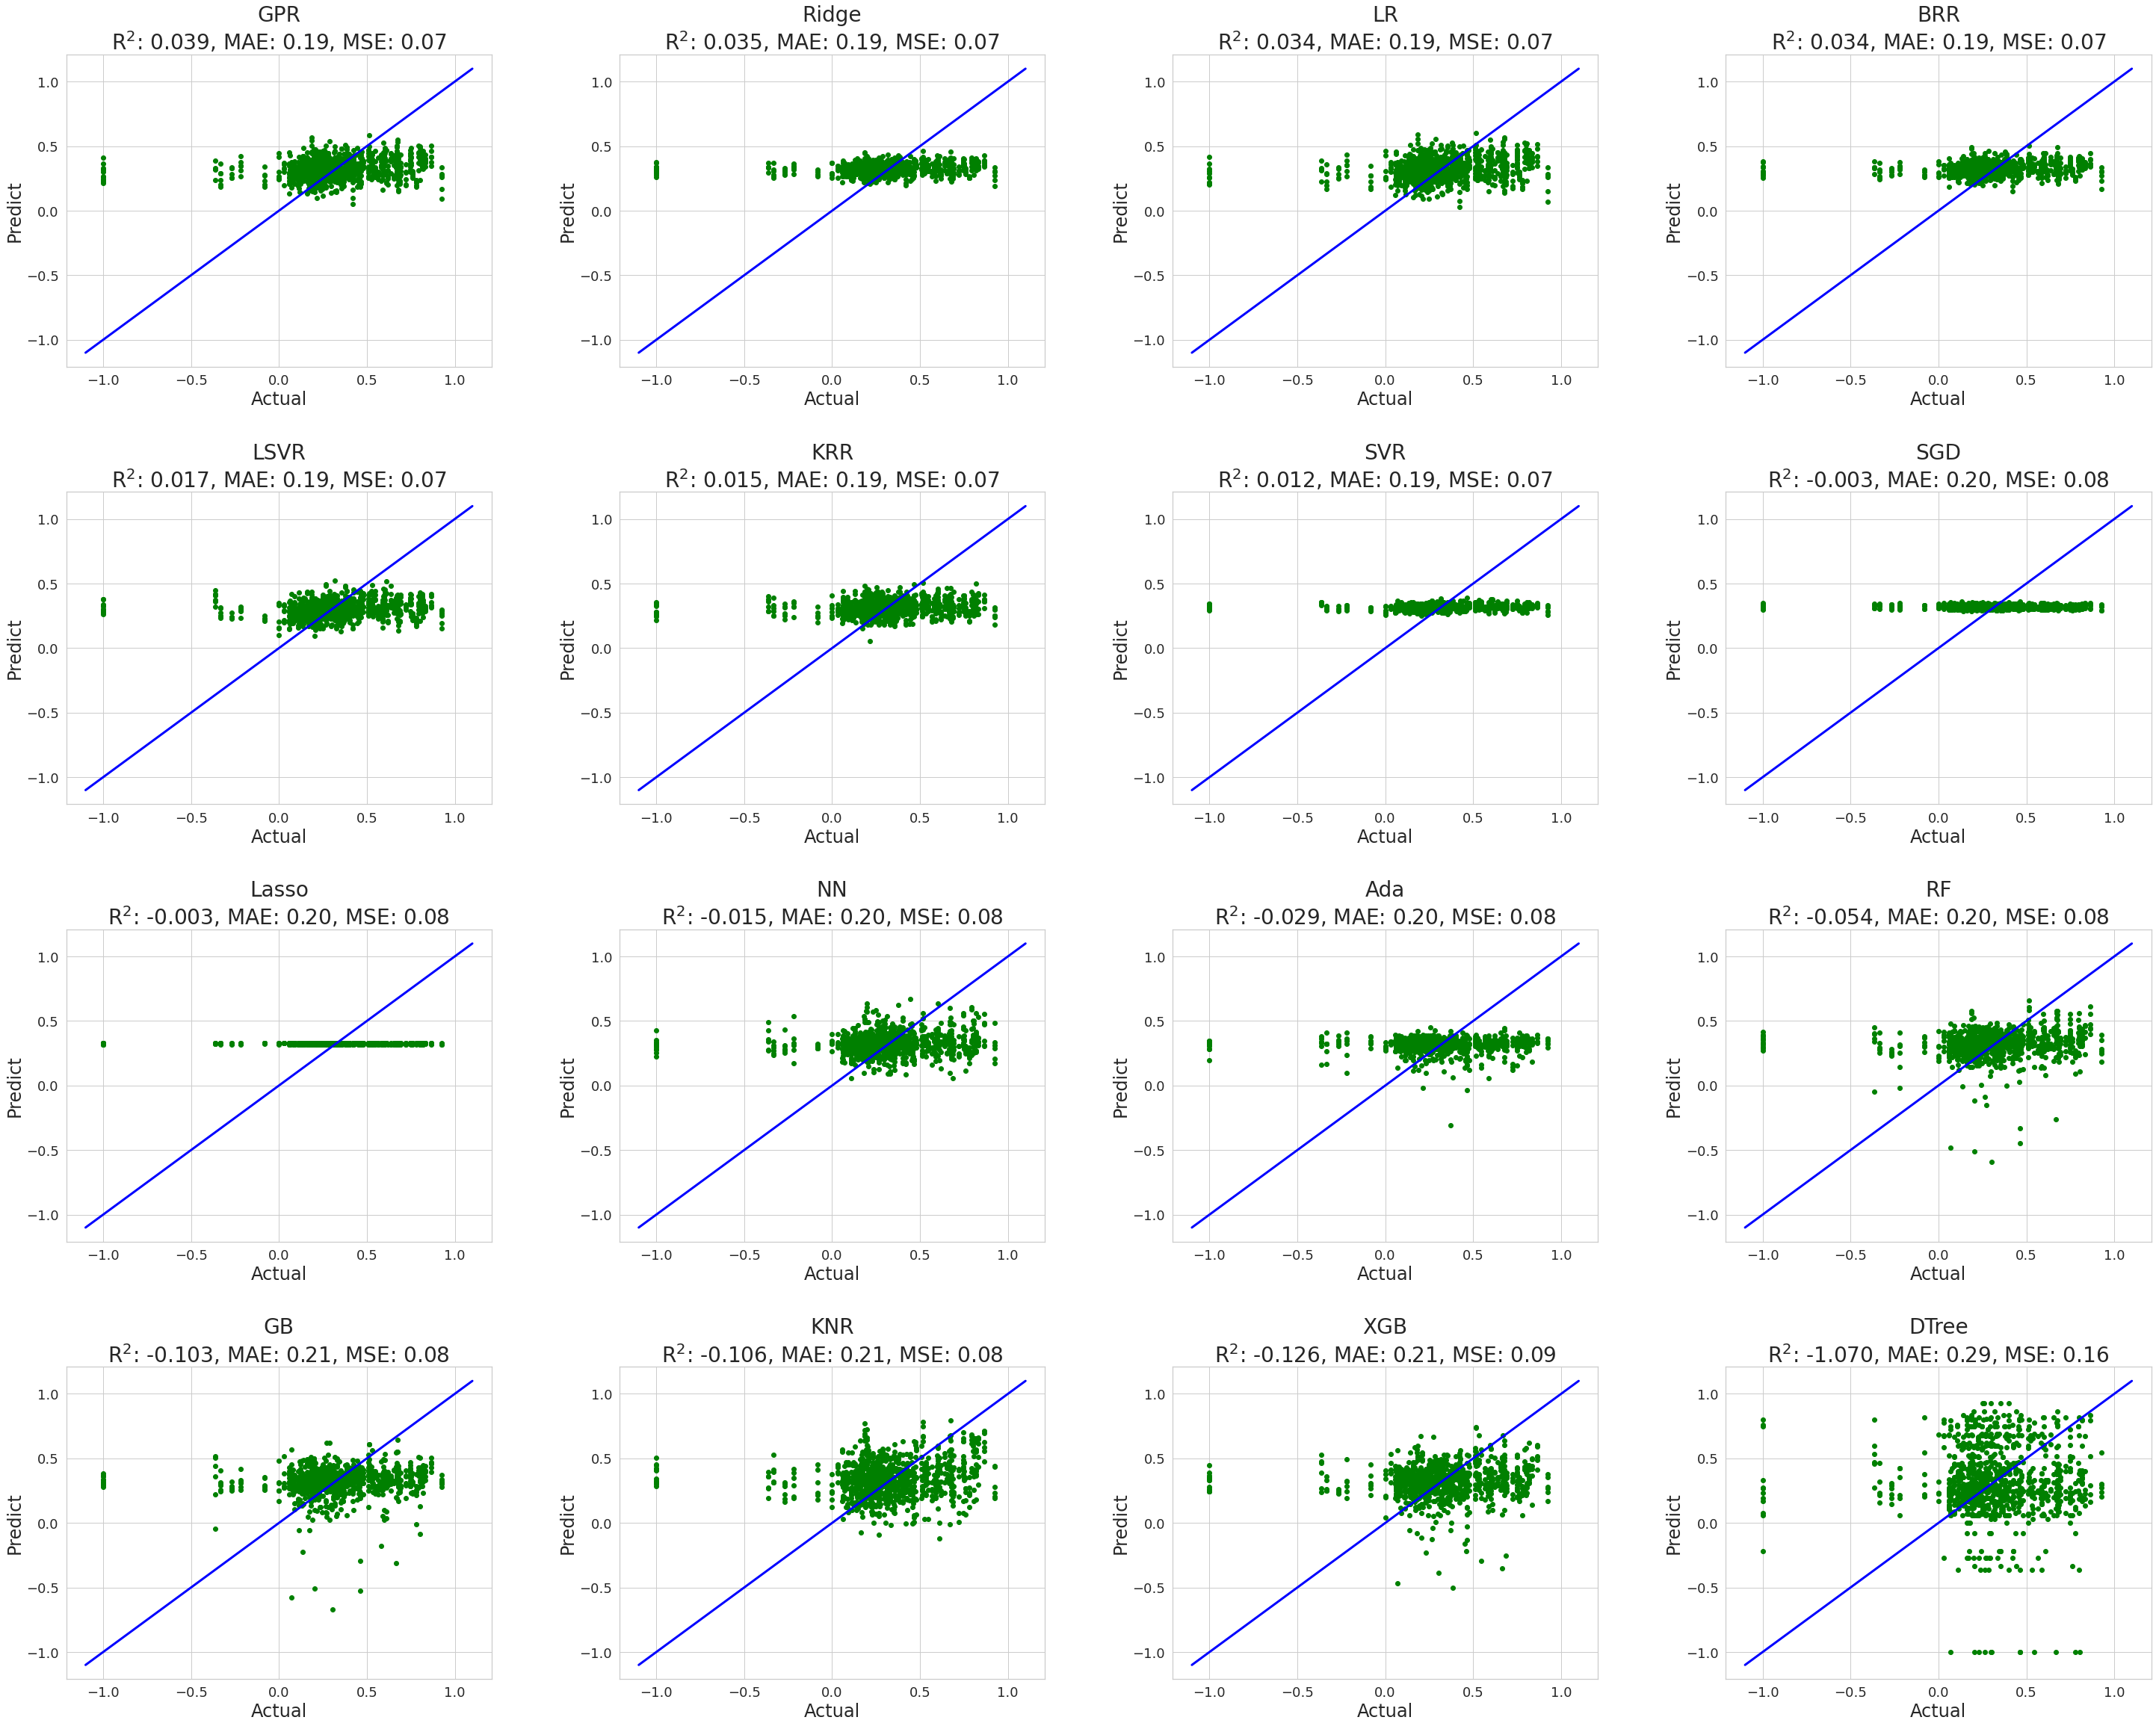

In [30]:
Plot_True_vs_Pred(y_pred_dict, res_df.Model.values, low=-1.1, up=1.1)

## Reaction data set corpus 

In [31]:
# words2 is the reaction seq.
documents2 = [TaggedDocument(doc, [i]) for i, doc in enumerate(words2)]
doc2vec_model2 = Doc2Vec(documents2, vector_size=5, window=2, min_count=1, workers=4)

In [32]:
X2 = np.apply_along_axis(doc2vec_model2.infer_vector, axis=1, arr=words2)
X2

array([[ 0.08789227,  0.07503539,  0.10621134, -0.02176802,  0.08279262],
       [ 0.12716015,  0.07300361,  0.02443573, -0.03038589,  0.091655  ],
       [ 0.20471492,  0.02004   ,  0.03324456, -0.04800508,  0.00492785],
       ...,
       [ 0.17347357,  0.14008361, -0.03326019, -0.17773601,  0.02519844],
       [ 0.11123963,  0.15714197,  0.00354663, -0.14532863,  0.02309429],
       [ 0.21228561,  0.0196536 ,  0.02954499, -0.09790138,  0.03925758]],
      dtype=float32)

In [33]:
y2 = np.concatenate((df.iloc[:, 1], df.iloc[:, 1]), axis=0)
y2 = np.concatenate((y2, y2, y2), axis=0)
idx2 = ~np.isnan(y2)
X2, y2 = X2[idx2], y2[idx2]
X2, y2 = shuffle(X2, y2, random_state=1024)

In [34]:
res_df2, y_pred_dict2, history2 = CV_fit(X2, y2, model_lib=reg_lib, model_dict=reg_lib, n_jobs=2, parallel=False)
res_df2

2021.05.30 16:03:07 complete!
    Time cost: 4.8463s


,Model,MAE,MSE,R2
14,NN_R,0.1976,0.0748,0.0093
6,Ridge_R,0.1971,0.0749,0.0077
7,BRR_R,0.1968,0.0750,0.0070
13,GPR_R,0.1976,0.0751,0.0062
4,LR_R,0.1977,0.0751,0.0060
9,SVR_R,0.1951,0.0752,0.0039
5,Lasso_R,0.1961,0.0757,-0.0026
11,SGD_R,0.1959,0.0758,-0.0038
10,LSVR_R,0.1954,0.0768,-0.0165
0,RF_R,0.2067,0.0792,-0.0493


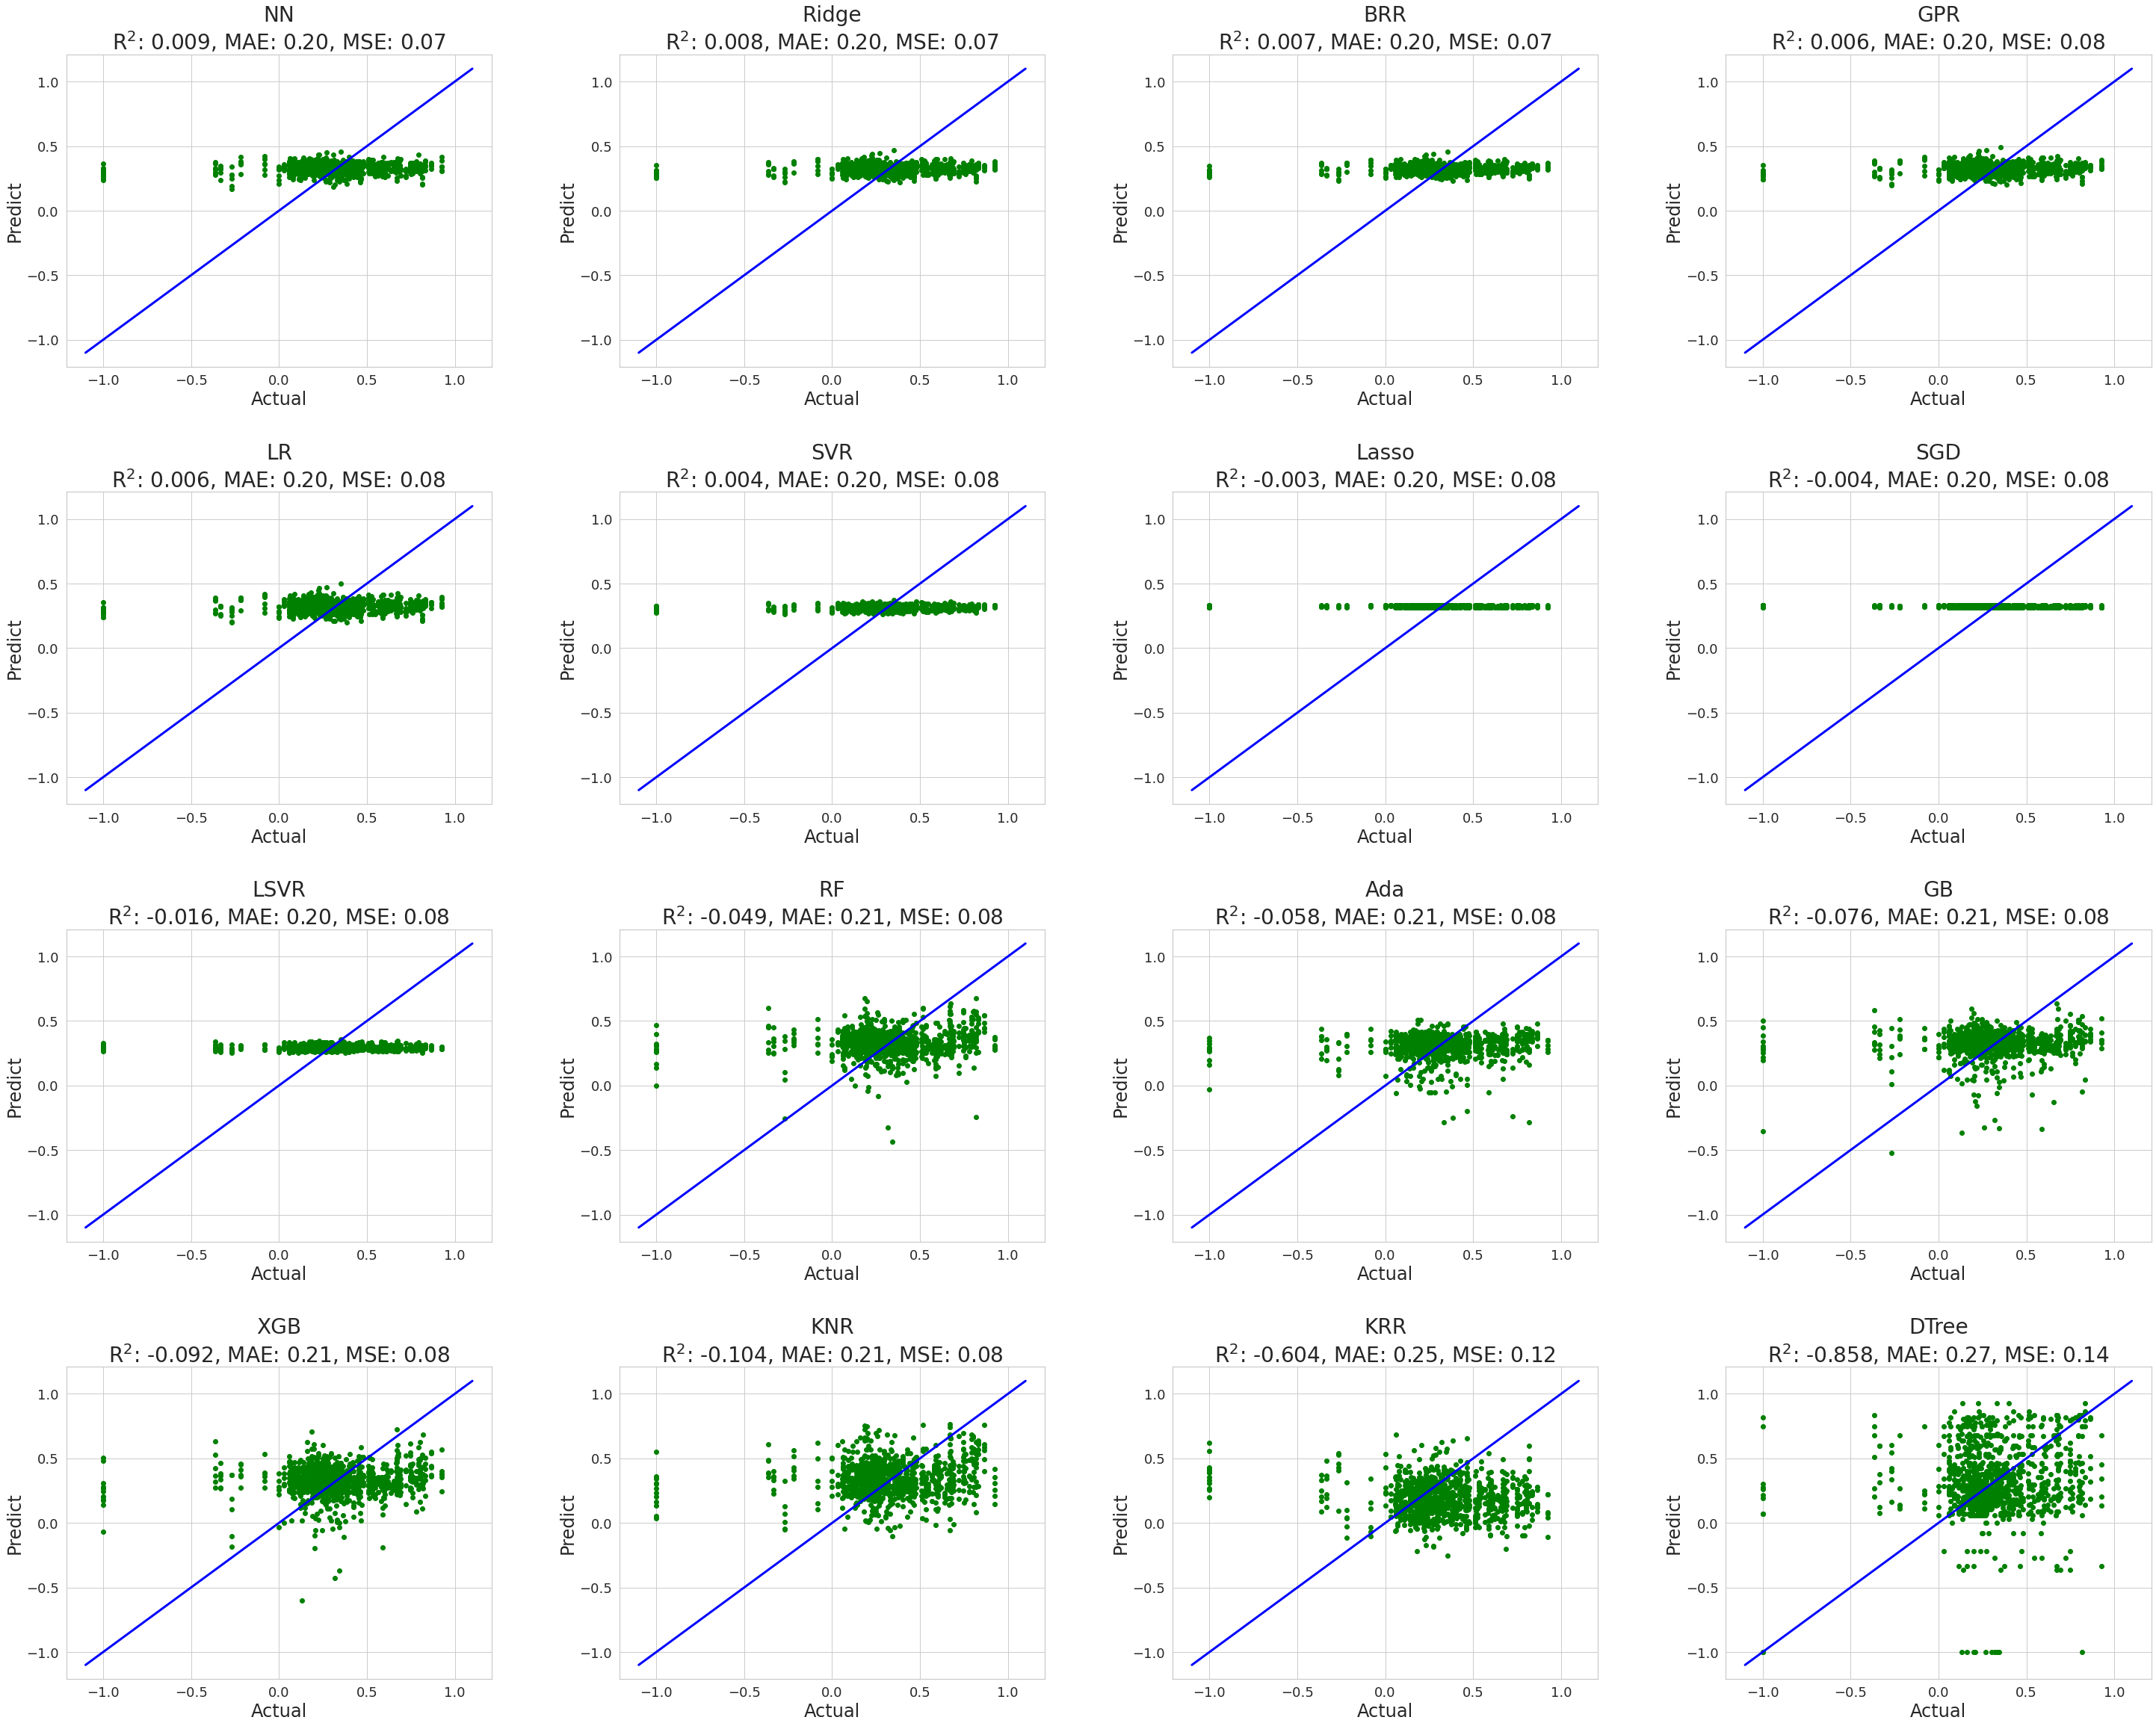

In [35]:
Plot_True_vs_Pred(y_pred_dict2, res_df2.Model.values, low=-1.1, up=1.1)

# Word2Vec

In [36]:
# pre-train
# words is the pocessed uniprot data 

from gensim.models import Word2Vec

model3 = Word2Vec(sentences=words.tolist(), vector_size=32, window=5, min_count=1, workers=4)
v3 = model3.wv['MCK']
v3

array([-0.05434296, -0.87178075, -0.00123839,  0.3505264 ,  0.36040395,
       -0.6520355 , -0.70833826,  0.13775457,  0.03968585,  0.09175581,
       -0.00582547, -0.11006907, -0.3371714 , -0.40997323, -0.41507193,
       -0.33106342, -0.12154479,  0.26727742, -0.09935366,  0.2589999 ,
       -0.05727515,  0.73766416, -0.01390006, -0.67131543,  0.34029993,
       -0.07020923, -0.29586765,  0.35532406,  0.2756966 ,  0.2733645 ,
        0.08640476,  0.13730681], dtype=float32)

In [37]:
words.tolist()

[['**M', 'TMD', 'KSE', 'LVQ', 'KAK', 'LAE', 'QAE', 'RYD', 'DMA'],
 ['**A', 'AAM', 'KAV', 'TEQ', 'GHE', 'LSN', 'EER', 'NLL', 'SVA'],
 ['**A', 'YKN', 'VVG', 'ARR', 'SSW', 'RVI', 'SSI', 'EQK', 'TER'],
 ['**R', 'NEK', 'KQQ', 'MGK', 'EYR', 'EKI', 'EAE', 'LQD', 'ICN'],
 ['**N', 'DVL', 'ELL', 'DKY', 'LIP', 'NAT', 'QPE', 'SKV', 'FYL'],
 ['**K', 'MKG', 'DYF', 'RYL', 'SEV', 'ASG', 'DNK', 'QTT', 'VSN'],
 ['**S', 'QQA', 'YQE', 'AFE', 'ISK', 'KEM', 'QPT', 'HPI', 'RLG'],
 ['**L', 'ALN', 'FSV', 'FYY', 'EIL', 'NSP', 'EKA', 'CSL', 'AKT'],
 ['**A', 'FDE', 'AIA', 'ELD', 'TLN', 'EES', 'YKD', 'STL', 'IMQ'],
 ['**L', 'LRD', 'NLT', 'LWT', 'SEN', 'QGD', 'EGD', 'AGE', 'GEN'],
 ['**M', 'DDR', 'EDL', 'VYQ', 'AKL', 'AEQ', 'AER', 'YDE', 'MVE'],
 ['**V', 'ESM', 'KKV', 'AGM', 'DVE', 'LTV', 'EER', 'NLL', 'SVA'],
 ['**V', 'AYK', 'NVI', 'GAR', 'RAS', 'WRI', 'ISS', 'IEQ', 'KEE'],
 ['**E', 'ENK', 'GGE', 'DKL', 'KMI', 'REY', 'RQM', 'VET', 'ELK'],
 ['**L', 'KLI', 'CCD', 'ILD', 'VLD', 'KHL', 'IPA', 'ANT', 'GES'],
 ['**E', '

In [38]:
X3 = np.array([model3.wv[i].flatten() for i in df.key_words.values])
y3 = df.iloc[:, 1]
idx3 = ~np.isnan(y3)
X3, y3 = X3[idx3], y3[idx3]
X3, y3 = shuffle(X3, y3, random_state=1024)
X3

array([[-4.7700021e-01, -3.3186004e-01, -3.1154305e-01, ...,
         4.2719942e-01, -7.2457516e-01,  6.2927121e-01],
       [-4.7700021e-01, -3.3186004e-01, -3.1154305e-01, ...,
         5.2840773e-02, -8.5514295e-01,  1.0260834e+00],
       [-1.2590443e-01, -6.1564490e-02, -2.9781213e-01, ...,
         1.0186764e+00, -7.3504382e-01,  1.3898032e+00],
       ...,
       [-9.7120345e-02, -4.8621613e-01,  1.0490498e-01, ...,
         5.2840773e-02, -8.5514295e-01,  1.0260834e+00],
       [-8.0683105e-02, -5.9658462e-01, -2.7803743e-01, ...,
         9.9333924e-01, -7.9355198e-01,  1.2141951e+00],
       [-5.4342963e-02, -8.7178075e-01, -1.2383871e-03, ...,
        -8.3752364e-02,  6.2449282e-01,  1.1614782e-01]], dtype=float32)

In [39]:
X3.shape

(168, 96)

In [40]:
res_df3, y_pred_dict3, history3 = CV_fit(X3, y3, model_lib=reg_lib, model_dict=reg_lib, n_jobs=2, parallel=False)
res_df3

/home/user/miniconda/envs/py36/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/user/miniconda/envs/py36/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/user/miniconda/envs/py36/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/user/miniconda/envs/py36/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/user/miniconda/envs/py36/lib/python3.8/site-packages/sklearn/svm/_base.py:985: Con

2021.05.30 16:03:46 complete!
    Time cost: 2.5534s


,Model,MAE,MSE,R2
9,SVR_R,0.1768,0.0691,0.0844
11,SGD_R,0.1918,0.0743,0.0167
5,Lasso_R,0.1962,0.0759,-0.0045
7,BRR_R,0.1946,0.0759,-0.0055
12,KNR_R,0.2000,0.0788,-0.0430
10,LSVR_R,0.1924,0.0798,-0.0561
0,RF_R,0.1989,0.0843,-0.1156
8,KRR_R,0.2077,0.0882,-0.1680
13,GPR_R,0.2077,0.0883,-0.1685
6,Ridge_R,0.2076,0.0886,-0.1733


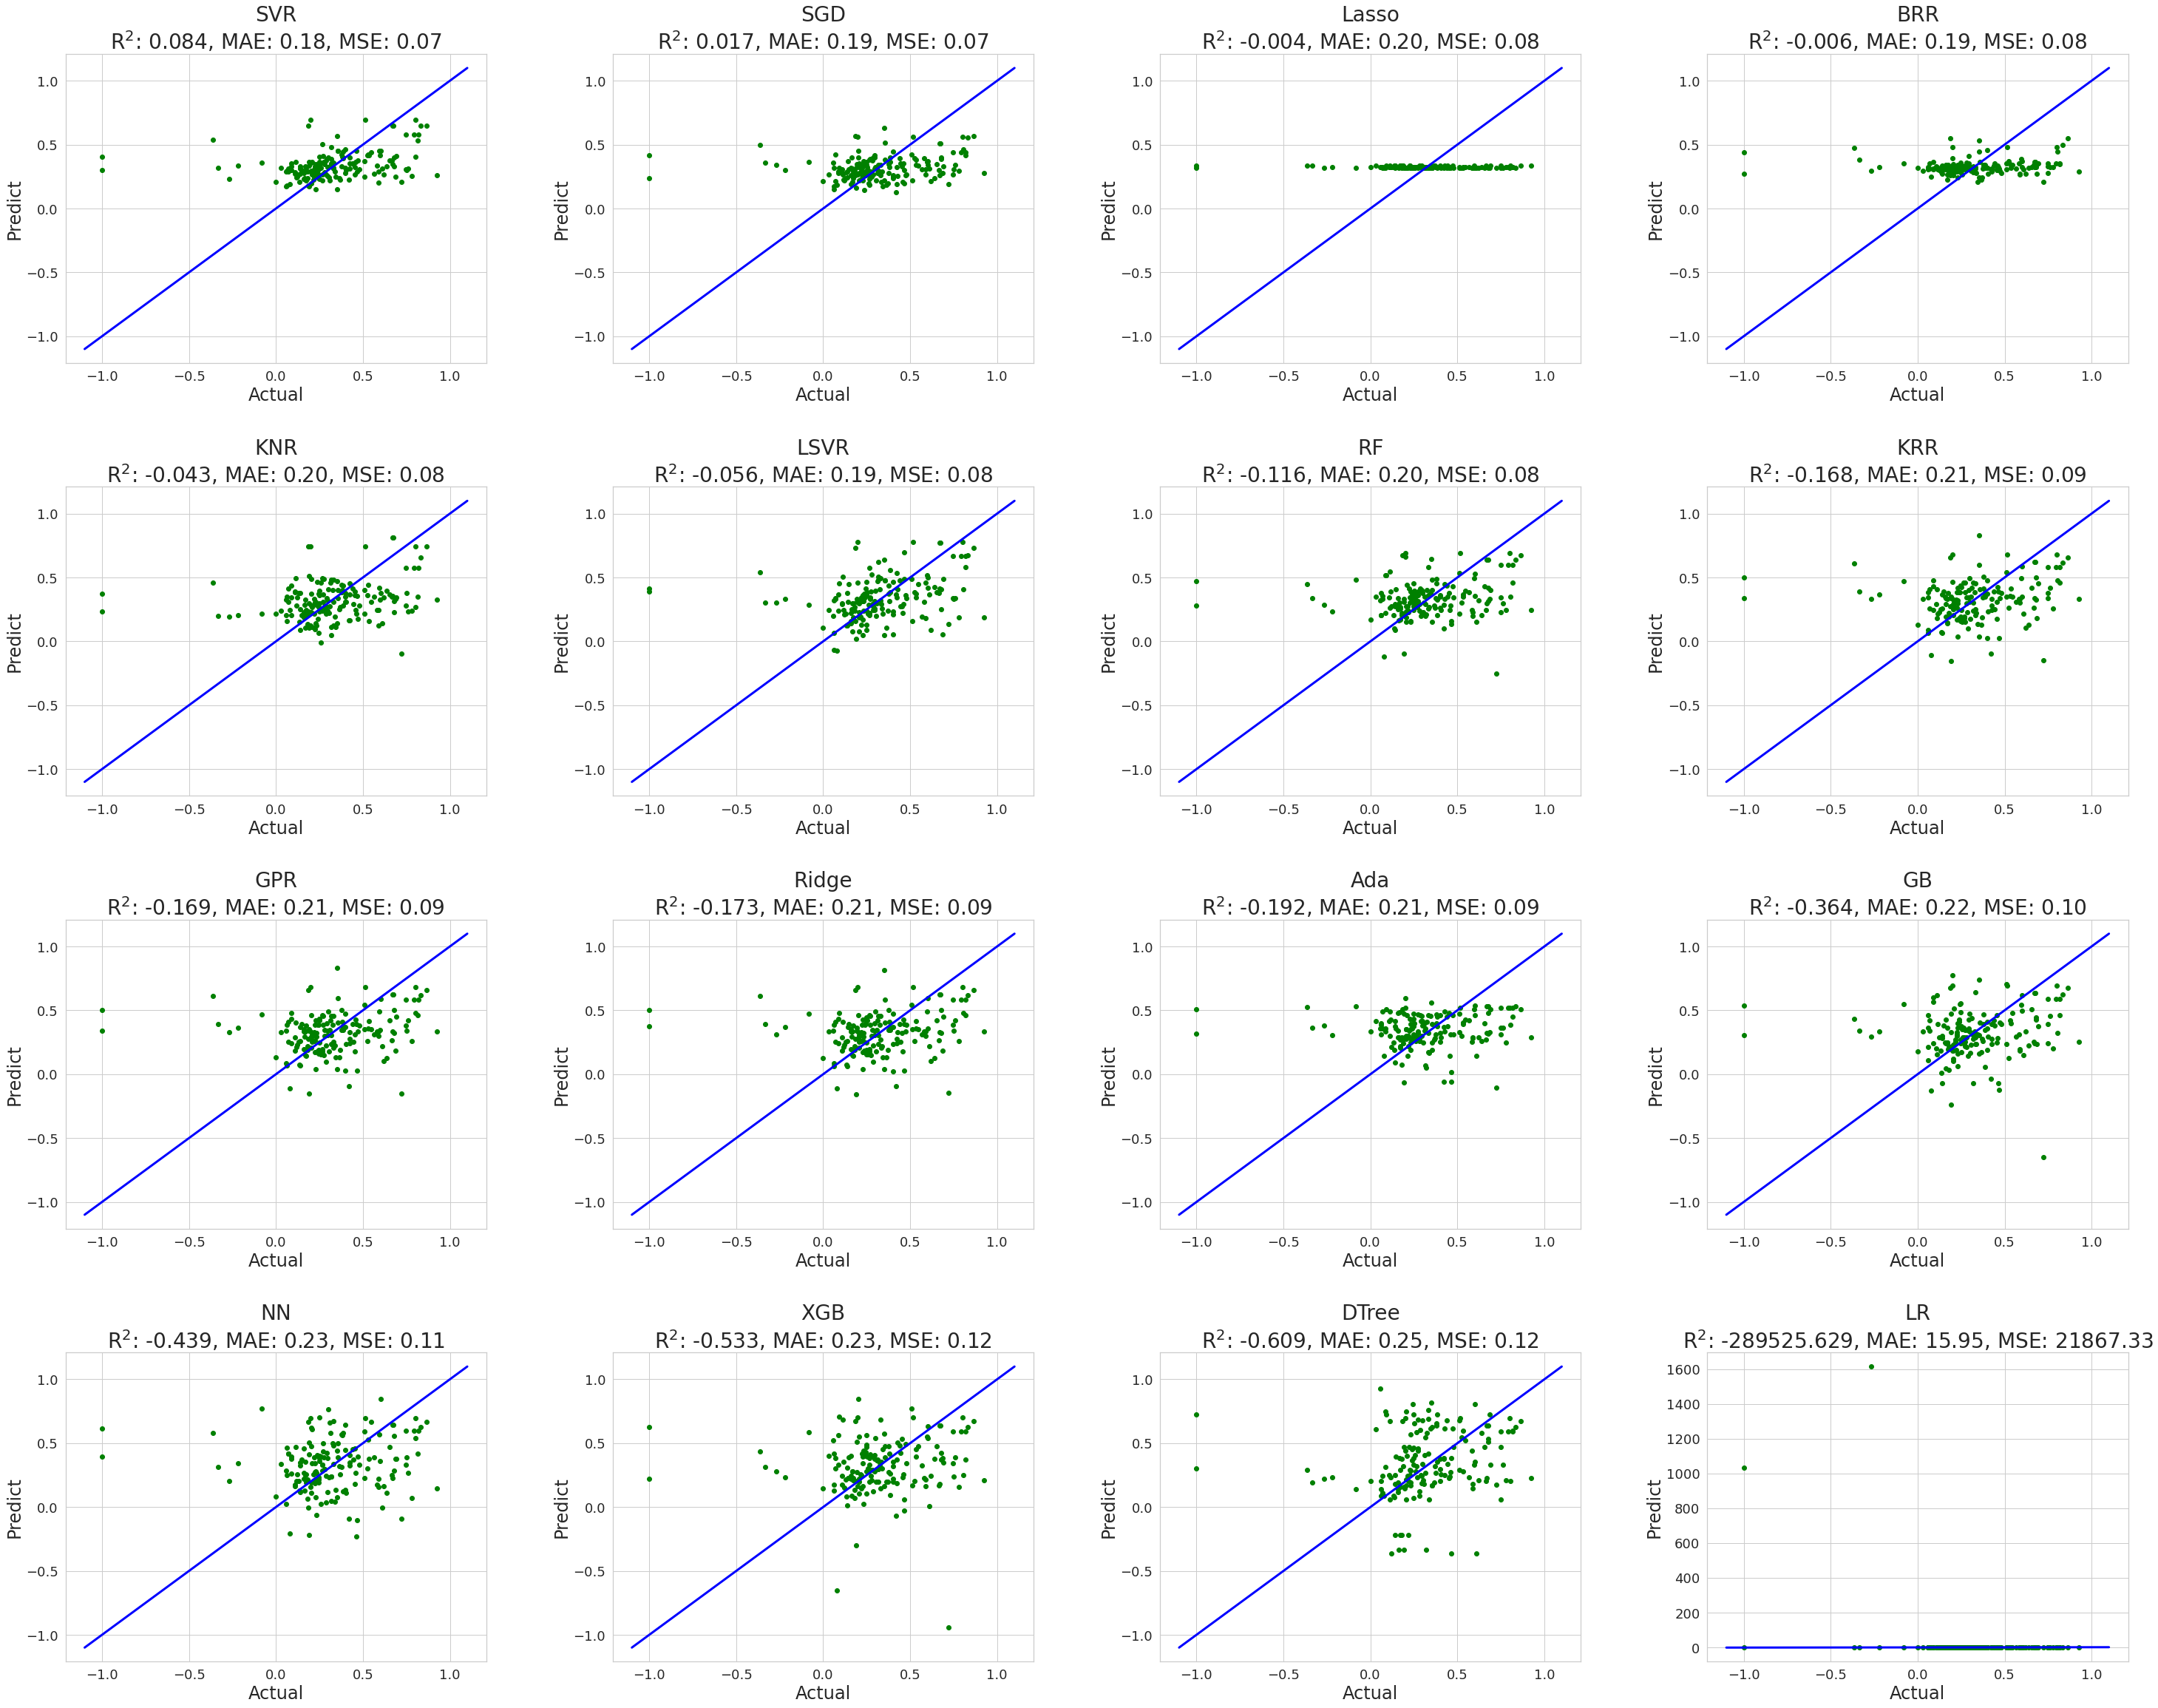

In [41]:
Plot_True_vs_Pred(y_pred_dict3, res_df3.Model.values, low=-1.1, up=1.1)

# AAindex Descriptors

+ AAindex is a database of numerical indices representing various physicochemical and biochemical properties of amino acids and pairs of amino acids.

In [42]:
from propy import AAIndex as AAI

pro_lays = ["ANDN920101", "ARGP820101", "ARGP820102", "ARGP820103", "BEGF750101", "BEGF750102", "BEGF750103", "BHAR880101"]


In [43]:
def get_AAindex(prot_list):
    aaindex = [[AAI.GetAAIndex1(each_prop)[amino]
                for each_prop in pro_lays] for amino in prot_list]
    return np.array(aaindex).flatten()

X4 = np.array([get_AAindex(i) for i in df.key_AA.values])
X4

array([[4.65 , 1.07 , 1.89 , ..., 0.98 , 0.37 , 0.462],
       [4.65 , 1.07 , 1.89 , ..., 0.98 , 0.53 , 0.314],
       [4.65 , 1.07 , 1.89 , ..., 0.55 , 0.97 , 0.463],
       ...,
       [3.95 , 1.32 , 1.08 , ..., 0.83 , 0.84 , 0.42 ],
       [3.95 , 2.22 , 1.45 , ..., 0.65 , 0.84 , 0.346],
       [3.95 , 1.32 , 1.08 , ..., 0.72 , 0.84 , 0.529]])

In [44]:
y4 = df.iloc[:, 1]
idx4 = ~np.isnan(y4)
X4, y4 = X4[idx4], y4[idx4]
X4, y4 = shuffle(X4, y4, random_state=1024)
X4

array([[4.17 , 1.53 , 3.23 , ..., 0.98 , 0.37 , 0.386],
       [4.17 , 1.53 , 3.23 , ..., 0.98 , 0.37 , 0.462],
       [3.95 , 1.32 , 1.08 , ..., 0.65 , 0.97 , 0.511],
       ...,
       [4.6  , 1.88 , 0.39 , ..., 0.98 , 0.37 , 0.462],
       [3.97 , 0.07 , 0.49 , ..., 0.55 , 0.97 , 0.463],
       [4.65 , 1.07 , 1.89 , ..., 0.65 , 0.84 , 0.346]])

In [45]:
X4.shape

(168, 24)

In [46]:
res_df4, y_pred_dict4, history4 = CV_fit(X4, y4, model_lib=reg_lib, model_dict=reg_lib, n_jobs=2, parallel=False)
res_df4

/home/user/miniconda/envs/py36/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/user/miniconda/envs/py36/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/user/miniconda/envs/py36/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/user/miniconda/envs/py36/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/user/miniconda/envs/py36/lib/python3.8/site-packages/sklearn/svm/_base.py:985: Con

2021.05.30 16:05:52 complete!
    Time cost: 1.5657s


,Model,MAE,MSE,R2
9,SVR_R,0.1923,0.0756,-0.0004
5,Lasso_R,0.1962,0.0759,-0.0045
6,Ridge_R,0.1981,0.0775,-0.0266
8,KRR_R,0.1981,0.0776,-0.0280
7,BRR_R,0.1944,0.0777,-0.0293
11,SGD_R,0.1949,0.0783,-0.0364
13,GPR_R,0.2066,0.0819,-0.0847
10,LSVR_R,0.2023,0.0819,-0.0849
12,KNR_R,0.2099,0.0829,-0.0983
0,RF_R,0.2001,0.0835,-0.1062


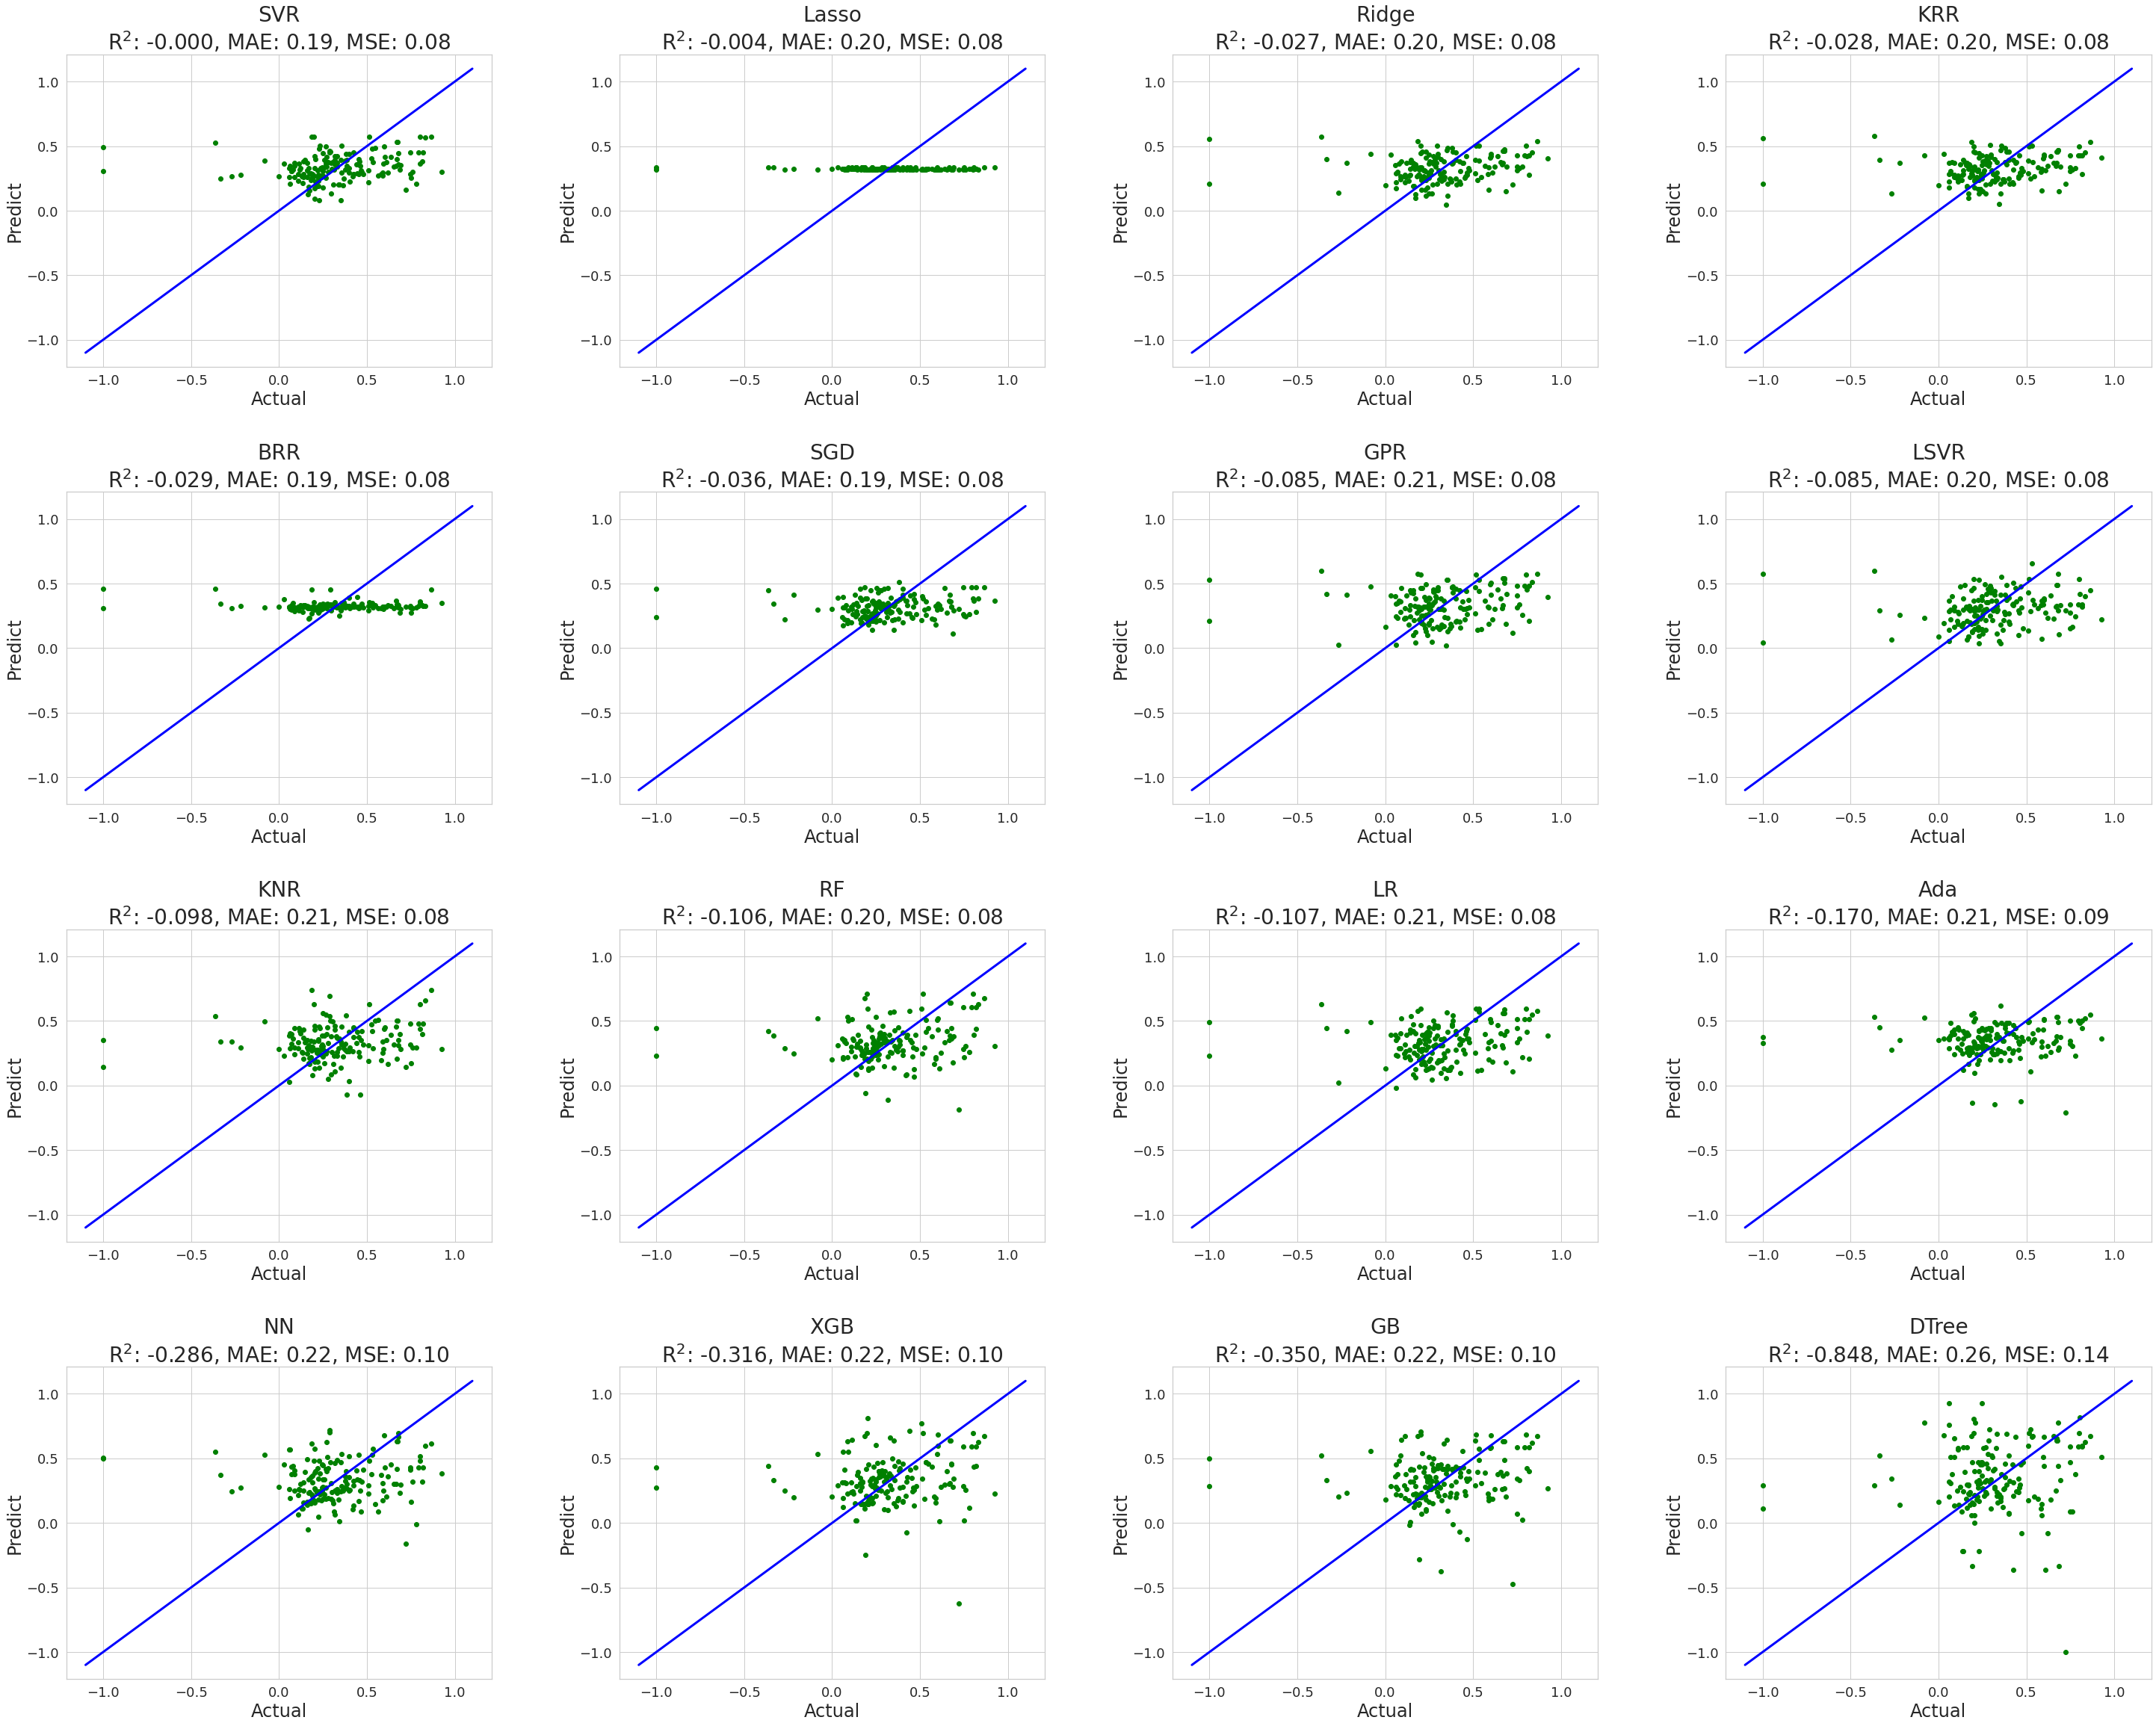

In [47]:
Plot_True_vs_Pred(y_pred_dict4, res_df4.Model.values, low=-1.1, up=1.1)